In [1]:
#Import the modules required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import itertools
import pdb

In [2]:
#Name the headers of the data and read the file
colName = ['lettr','x-box','ybox','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx'];
data = pd.read_csv('LRD.data',header = None, names = colName);

In [3]:
#Check how the dataset looks like
data.head()

,lettr,x-box,ybox,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [4]:
#Size of the data
data.shape

(20000, 17)

In [5]:
#Check for missing values
pd.isnull(data).sum()

lettr    0
x-box    0
ybox     0
width    0
high     0
onpix    0
x-bar    0
y-bar    0
x2bar    0
y2bar    0
xybar    0
x2ybr    0
xy2br    0
x-ege    0
xegvy    0
y-ege    0
yegvx    0
dtype: int64

There are no missing values in our data! Now, lets see the distribution of our classes

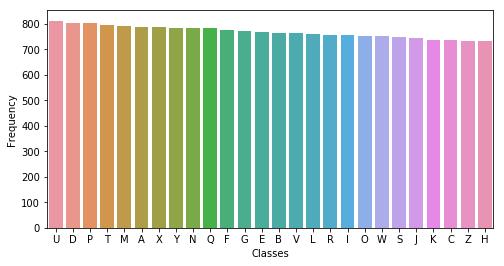

In [6]:
#Check whether the classes are balanced or not
plt.subplots(figsize=(8,4))
sns.barplot(x = data['lettr'].value_counts().index, y = data['lettr'].value_counts().values);
plt.xlabel('Classes');
plt.ylabel('Frequency');

The dataset is indeed balanced. The first step is dividing the data into training and test. For that purpose, the instances of each classes are divided into a split of 80-20 and shuffled after splitting in the function below:-

In [7]:
#Function that divides the data into training and test randomly
def Preprocessing(df):
    labels_train = pd.DataFrame();
    features_train = pd.DataFrame();
    labels_test = pd.DataFrame();
    features_test = pd.DataFrame();
    #Seperate features and labels of each class
    for i in range(26):
        labels_class = df.lettr[df['lettr'] == chr(ord('A') + i)];
        features_class = df[df['lettr'] == chr(ord('A') + i)].drop(['lettr'], axis = 1);
        index = np.random.permutation(len(labels_class)); #Random Indexes to divide the dataset into train and test
        labels_train = pd.concat([labels_train, labels_class.iloc[index[0:650:1]]]);
        features_train = pd.concat([features_train, features_class.iloc[index[0:650:1]]]);
        labels_test = pd.concat([labels_test, labels_class.iloc[index[650:len(labels_class)]]]);
        features_test = pd.concat([features_test, features_class.iloc[index[650:len(labels_class)]]]);
    #Shuffle the training data
    shuff = np.random.permutation(len(labels_train));
    labels_train = labels_train.iloc[shuff];
    features_train = features_train.iloc[shuff];
    #Shuffle the test data
    shuff = np.random.permutation(len(labels_test));
    labels_test = labels_test.iloc[shuff];
    features_test = features_test.iloc[shuff];

    return labels_train, features_train, labels_test, features_test;

In [8]:
labels_train, features_train, labels_test, features_test = Preprocessing(data);
labels_train.columns = ['lettr'];
labels_test.columns = ['lettr'];

In [9]:
#Naive Bayes Models

#Find the prior probability of each class
prior = np.zeros((26,1));

for i in range(26):
    prior[i] = (labels_train == chr(ord('A') + i)).sum()/len(labels_train);

#Seperate the features of each class and find the probability matrix(each feature)
likelihood = np.zeros((26,16));

for i in range(26):
    tidx = labels_train == chr(ord('A') + i);
    temp = features_train[tidx.values];
    likelihood[i,:] = (1 + np.sum(temp,axis = 0))/np.sum(temp).sum();
    
#Classify using Multinomial Naivee Bayes
prob = np.zeros((26,1));
pred = np.ndarray(shape=(len(labels_test),1), dtype=object);

for i in range(len(labels_test)):
    for j in range(26):
        prob[j] = np.log(prior[j]) + np.sum(np.log(likelihood[j,:])*features_test.iloc[i])
    maxIndex = np.argmax(prob);
    pred[i] = chr(ord('A') + maxIndex);

Among the 3 different versions of Naive Bayes, Multinomial Multivariate Naive Bayes performs the best with an accuracy of 69-72% with relatively good precision and recall on average. Lets compare these methods to logistic regression and neural networks

In [13]:
#Normalize the features matrices for Neural Networks and logistic regression
features_train = features_train/15
features_test = features_test/15

In [14]:
def softmax(ar):
    exps = np.exp(ar)
    denom = sum(exps)
    softmax = exps/denom
    return softmax

In [15]:
#Implementation of Logistic regression using neural networks with SGD + momentum

#Initalize weight and bias using Xaviers Initialization
#Source:https://mnsgrg.com/2017/12/21/xavier-initialization/
b = -np.sqrt(6/(16+26)) + 2*np.sqrt(6/(16+26))*np.random.uniform(size = (26,1))
w = -np.sqrt(6/(16+26)) + 2*np.sqrt(6/(16+26))*np.random.uniform(size = (26,16))

#Initialize Variables
epoch = 50
lr = 0.01
alp = 0.35
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db = np.zeros((26,1))   #Gradient for bias
dw = np.zeros((26,16))  #Gradient for weight

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        tot = np.matmul(w,f) + b
        o = softmax(tot)

        #Backward Pass
        db = alp*db + lr*(o-lbl)
        dw = alp*dw + lr*np.matmul((o-lbl),np.transpose(f))
        b = b - db
        w = w - dw

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))
        tot = np.matmul(w,f) + b
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0
    
    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Minimum Error 
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db[:] = 0
    dw[:] = 0


In [16]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 76.839


In [17]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[129,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,
          0,   2,   0,   0,   1,   1,   1,   2,   0,   0,   0,   1,   0],
       [  0,  94,   0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   1,
          0,   3,   1,   2,   6,   3,   0,   0,   0,   0,   2,   1,   0],
       [  0,   0,  72,   0,   3,   0,   1,   0,   0,   0,   5,   1,   1,
          0,   1,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0],
       [  2,   5,   0, 121,   0,   0,   0,   1,   0,   2,   1,   1,   0,
          3,   3,   2,   0,   4,   1,   1,   2,   0,   0,   3,   0,   3],
       [  0,   0,   6,   0,  86,   0,   7,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   2,   1,   4,   2,   0,   0,   0,   3,   0,   6],
       [  0,   9,   2,   3,   1,  75,   4,   0,   1,   0,   0,   0,   0,
          0,   1,  11,   0,   2,   5,   9,   0,   0,   0,   0,   2,   0],
       [  5,   3,  31,   0,   0,   0,  43,   1,   0,   0,   7,   1,   1,
          0,   1,   1,  18,   2,   6,   0,   

In [18]:
#print(classification_report(labels_test, bpred, target_names=data.lettr))

Text(0,0.5,'Cross Entropy Error')

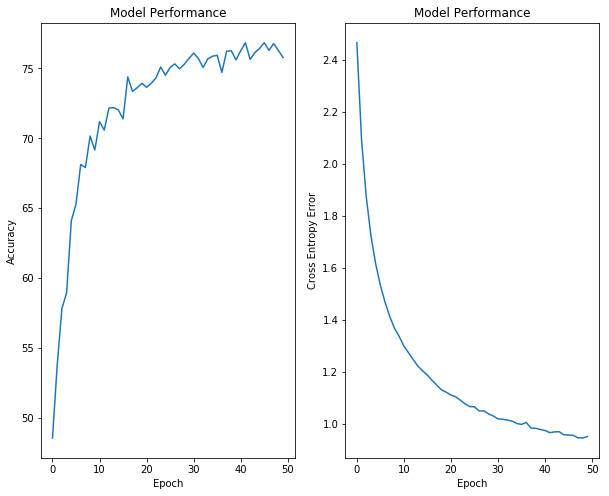

In [19]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(50),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(50),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

In [20]:
#Implementation of One layer neural networks with SGD + momentum

#Initalize weight and bias using Xaviers Initialization
#Source:https://mnsgrg.com/2017/12/21/xavier-initialization/
hn = 30 #Number of hidden neurons
b1 = -np.sqrt(6/(16+hn)) + 2*np.sqrt(6/(16+hn))*np.random.uniform(size = (hn,1))
w1 = -np.sqrt(6/(16+hn)) + 2*np.sqrt(6/(16+hn))*np.random.uniform(size = (hn,16))
b2 = -np.sqrt(6/(26+hn)) + 2*np.sqrt(6/(26+hn))*np.random.uniform(size = (26,1))
w2 = -np.sqrt(6/(26+hn)) + 2*np.sqrt(6/(26+hn))*np.random.uniform(size = (26,hn))

#Initialize Variables
epoch = 100
lr = 0.1
alp = 0.2
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db1 = np.zeros((hn,1))   #Gradient for bias
dw1 = np.zeros((hn,16))  #Gradient for weight
db2 = np.zeros((26,1))
dw2 = np.zeros((26,hn))

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        tot = np.matmul(w2,o1) + b2
        o = softmax(tot)

        #Backward Pass (Might be a little confusing, so try doing the steps on a small matrix)
        db2 = alp*db2 + lr*(o-lbl)
        dw2 = alp*dw2+ lr*np.matmul((o-lbl),np.transpose(o1))
        db1 = alp*db1 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w2))*o1*(1-o1)
        dw1 = alp*dw1 + np.matmul((np.transpose(lr*np.matmul(np.transpose(o-lbl),w2))*o1*(1-o1)),np.transpose(f))

        b1 = b1 - db1
        w1 = w1 - dw1
        b2 = b2 - db2
        w2 = w2 - dw2

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))

        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        tot = np.matmul(w2,o1) + b2
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0

    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Early Stopping condition
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db1[:] = 0
    dw1[:] = 0
    db2[:] = 0
    dw2[:] = 0


In [21]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 91.355


In [22]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[136,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 105,   0,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   2,   2,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,  84,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 144,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          2,   1,   0,   0,   0,   0,   2,   1,   0,   0,   2,   0,   0],
       [  0,   0,   3,   0,  97,   2,   2,   0,   0,   0,   2,   0,   0,
          0,   0,   0,   0,   1,   0,   2,   0,   0,   0,   3,   0,   6],
       [  0,   2,   0,   1,   2, 102,   1,   0,   5,   2,   0,   0,   0,
          0,   0,   9,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  2,   1,  12,   1,   1,   0,  94,   2,   0,   0,   1,   1,   0,
          0,   0,   1,   5,   0,   0,   0,   

In [23]:
#print(classification_report(labels_test, bpred, target_names=data.lettr))

Text(0,0.5,'Cross Entropy Error')

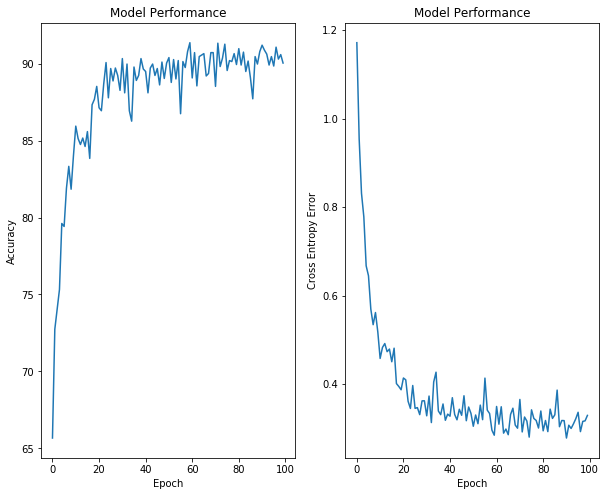

In [24]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(100),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(100),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

In [25]:
#Implementation of 2-layer neural networks with SGD + momentum

#Initalize weight and bias using Xaviers Initialization
#Source:https://mnsgrg.com/2017/12/21/xavier-initialization/
hn1 = 64 #Number of hidden neurons in layer 1
hn2 = 32 #Number of hidden neurons in layer 2
b1 = -np.sqrt(6/(16+hn1)) + 2*np.sqrt(6/(16+hn1))*np.random.uniform(size = (hn1,1))
w1 = -np.sqrt(6/(16+hn1)) + 2*np.sqrt(6/(16+hn1))*np.random.uniform(size = (hn1,16))
b2 = -np.sqrt(6/(hn1+hn2)) + 2*np.sqrt(6/(hn1+hn2))*np.random.uniform(size = (hn2,1))
w2 = -np.sqrt(6/(hn1+hn2)) + 2*np.sqrt(6/(hn1+hn2))*np.random.uniform(size = (hn2,hn1))
b3 = -np.sqrt(6/(26+hn2)) + 2*np.sqrt(6/(26+hn2))*np.random.uniform(size = (26,1))
w3 = -np.sqrt(6/(26+hn2)) + 2*np.sqrt(6/(26+hn2))*np.random.uniform(size = (26,hn2))


#Initialize Variables
epoch = 100
lr = 0.05
alp = 0.008
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db1 = np.zeros((hn1,1))   #Gradient for bias
dw1 = np.zeros((hn1,16))  #Gradient for weight
db2 = np.zeros((hn2,1))
dw2 = np.zeros((hn2,hn1))
db3 = np.zeros((26,1))
dw3 = np.zeros((26,hn2))

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        l2 = np.matmul(w2,o1) + b2
        o2 = 1/(1 + np.exp(-l2))
        tot = np.matmul(w3,o2) + b3
        o = softmax(tot)

        #Backward Pass (Might be a little confusing, so try doing the steps on a small matrix)
        #pdb.set_trace()
        db3 = alp*db3 + lr*(o-lbl)
        dw3 = alp*db3 + lr*np.matmul((o-lbl),np.transpose(o2))
        db2 = alp*db2 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)
        dw2 = alp*dw2 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)*np.transpose(o1)
        db1 = alp*db1 + np.transpose(np.matmul(np.transpose(np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)),w2))*o1*(1-o1)
        dw1 = alp*dw1 + np.matmul(np.transpose(np.matmul(np.transpose(np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)),w2))*o1*(1-o1),np.transpose(f))

        b1 = b1 - db1
        w1 = w1 - dw1
        b2 = b2 - db2
        w2 = w2 - dw2
        b3 = b3 - db3
        w3 = w3 - dw3

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))

        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        l2 = np.matmul(w2,o1) + b2
        o2 = 1/(1 + np.exp(-l2))
        tot = np.matmul(w3,o2) + b3
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0

    #pdb.set_trace()
    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Early Stopping condition
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db1[:] = 0
    dw1[:] = 0
    db2[:] = 0
    dw2[:] = 0


In [26]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 95.968


In [27]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[139,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 110,   0,   0,   1,   0,   0,   2,   0,   0,   0,   0,   1,
          0,   1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,  85,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 151,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   3,   0, 107,   1,   2,   0,   0,   0,   1,   2,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0],
       [  0,   1,   0,   0,   0, 118,   0,   0,   4,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0, 118,   0,   0,   0,   0,   0,   0,
          0,   2,   0,   1,   0,   0,   0,   

In [28]:
#print(classification_report(labels_test, bpred, target_names=data.lettr))

Text(0,0.5,'Cross Entropy Error')

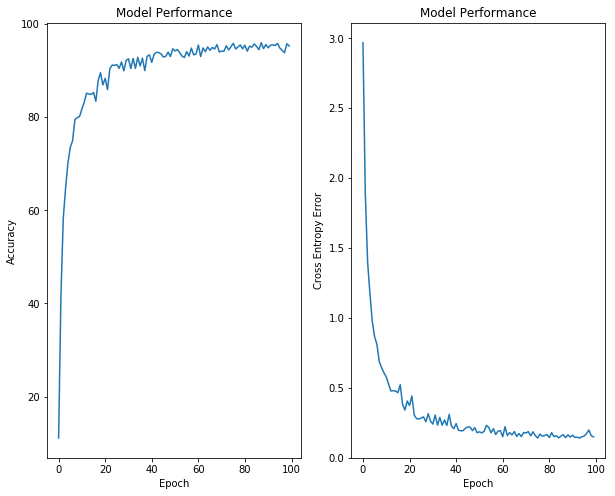

In [29]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(100),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(100),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

The best machine learning models for tabular data like the one shown above are decision trees and random forests. Our neural network with 2 hidden layers does relatively very well on the dataset achieving 95-96% accuracy. Lets see how good this performance is compared to decision trees and random forests.

Using just decision trees results in an accuracy of 87% which is poorer than our Nerual Net. However, Random Forests (no of trees - 50) out-perform the neural networks, although by just a small margin. This shows that our networks performance is good enough!  